In [1]:
from skimage import io
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Lambda

# Utilities
from matplotlib import pylab as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
def points_xy_as_dictionary(points_xy):
    points = {'x':[], 'y':[]}
    for i, val in enumerate(points_xy):
        points['x' if i % 2 == 0 else 'y'].append(val)
    return points

In [3]:
img = io.imread('img.jpg')
points_xy = [51,51,127,60,169,65,203,52,68,77,85,75,110,82,160,87,171,79,193,84,156,144,92,174,140,180,168,179]
points = points_xy_as_dictionary(points_xy)
points

{'x': [51, 127, 169, 203, 68, 85, 110, 160, 171, 193, 156, 92, 140, 168],
 'y': [51, 60, 65, 52, 77, 75, 82, 87, 79, 84, 144, 174, 180, 179]}

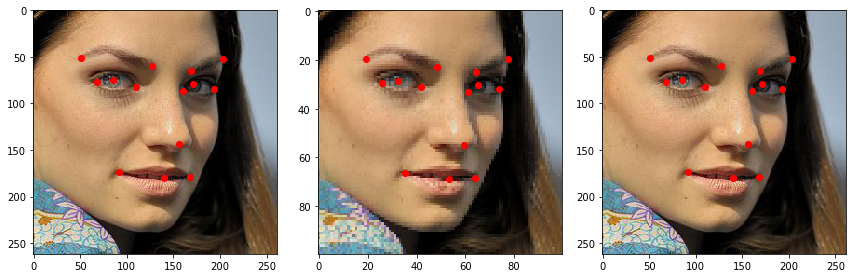

In [82]:
plt.figure(figsize=(12, 12))

plt.subplot(131)
io.imshow(img)
plt.plot(points['x'], points['y'], 'ro')

resized = resize_image(img)
resized_points_xy = map_points(img, resized, points_xy)
resized_points = points_xy_as_dictionary(resized_points_xy)
plt.subplot(132)
io.imshow(resized)
plt.plot(resized_points['x'], resized_points['y'], 'ro')

resized_points = points_xy_as_dictionary(map_points(resized, img, resized_points_xy))
plt.subplot(133)
io.imshow(img)
plt.plot(resized_points['x'], resized_points['y'], 'ro');

In [123]:
model = Sequential([
    Flatten(input_shape=(100, 100, 3)),
    Dense(units=1, activation='relu'),
    Dense(units=28, activation='relu')
])

model.compile(optimizer='rmsprop', loss='mse')

In [125]:
model.fit(np.arange(100 * 100 * 3).reshape((1, 100, 100, 3)), np.arange(28).reshape(1, 28))

Epoch 1/10
1/1 [==============================] - 0s - loss: 78516864.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 3/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 4/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 6/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 247.5000
Epoch 10/10
1/1 [==============================] - 0s - loss: 247.5000


In [126]:
x = model.predict(np.arange(2 * 100 * 100 * 3).reshape(2, 100, 100, 3))

In [122]:
def resize_image(image):
    from skimage.transform import resize
    return resize(image, (100, 100, 3), mode='reflect')


def map_points(src_image, dst_image, src_points):
    h_coeff, w_coeff = dst_image.shape[0] / src_image.shape[0], dst_image.shape[1] / src_image.shape[1]
    return [val * (w_coeff if i % 2 == 0 else h_coeff) for i, val in enumerate(src_points)]
########################################################################################################################
def create_model(input_shape, outputs):
    from keras.models import Sequential
    from keras.layers import Dense, Flatten
    
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(units=1, activation='relu'),
        Dense(units=outputs, activation='relu')
    ])
    
    model.compile(optimizer='rmsprop', loss='mse')
    return model


def train_detector(train_gt, train_img_dir, fast_train=False, model_name='facepoints_model.hdf5'):
    import numpy as np
    from os import listdir
    from os.path import join
    from skimage.io import imread
    from skimage.transform import resize
    
    P_POINTS_COUNT = 14 # count of principal points to search
    P_POINTS_COORDS_COUNT = 2 * P_POINTS_COUNT
    IMAGE_SHAPE = (100, 100, 3)
    SAMPLES_COUNT = len(train_gt)
    
    x_train = np.ndarray((SAMPLES_COUNT,) + IMAGE_SHAPE, dtype=np.float64)
    y_train = np.ndarray((SAMPLES_COUNT, P_POINTS_COORDS_COUNT), dtype=np.float64)
    sample = 0
    for filename in listdir(train_img_dir):
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            path_to_file = join(train_img_dir, filename)
            image = imread(path_to_file)
            coeff_x, coeff_y = IMAGE_SHAPE[1] / image.shape[1], IMAGE_SHAPE[0] / image.shape[0]
            x_train[sample, :] = resize(image, IMAGE_SHAPE, mode='reflect').astype(np.float64)
            y_train[sample, :] = train_gt[filename].astype(np.float64) * \
                                 np.tile([coeff_x, coeff_y], P_POINTS_COUNT)
            sample += 1
    
    # TODO: fast_train
    model = create_model(IMAGE_SHAPE, P_POINTS_COORDS_COUNT)
    model.fit(x_train, y_train)
    model.save(model_name)
        

def detect(model, test_img_dir, image_shape=(100, 100, 3)):
    import numpy as np
    from os import listdir
    from os.path import join
    from skimage.io import imread
    from skimage.transform import resize
    
    test_size = 0
    for filename in listdir(test_img_dir):
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            test_size += 1
            
    x_test = np.ndarray((test_size,) + image_shape, dtype=np.float64)
    filenames = []
    test = 0
    for filename in listdir(test_img_dir):
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image = imread(path_to_file)
            x_train[test, :] = resize(image, image_shape, mode='reflect').astype(np.float64)
            filenames.append(filename)
            test += 1
    
    return {i: vec for i, vec in zip(filenames, model.predict(x_test))}

In [186]:
def normalize_images(images):
    from numpy import mean, std, tile
    y = images.copy()
    for i in range(3):
        y[:, :, :, i] = (y[:, :, :, i] - mean(images[:, :, :, i], axis=0)) / std(images[:, :, :, i], axis=0)
    return y

In [185]:
x

array([[[[  0.,   1.,   2.],
         [  3.,   4.,   5.],
         [  6.,   7.,   8.]],

        [[  9.,  10.,  11.],
         [ 12.,  13.,  14.],
         [ 15.,  16.,  17.]],

        [[ 18.,  19.,  20.],
         [ 21.,  22.,  23.],
         [ 24.,  25.,  26.]]],


       [[[ 27.,  28.,  29.],
         [ 30.,  31.,  32.],
         [ 33.,  34.,  35.]],

        [[ 36.,  37.,  38.],
         [ 39.,  40.,  41.],
         [ 42.,  43.,  44.]],

        [[ 45.,  46.,  47.],
         [ 48.,  49.,  50.],
         [ 51.,  52.,  53.]]],


       [[[ 54.,  55.,  56.],
         [ 57.,  58.,  59.],
         [ 60.,  61.,  62.]],

        [[ 63.,  64.,  65.],
         [ 66.,  67.,  68.],
         [ 69.,  70.,  71.]],

        [[ 72.,  73.,  74.],
         [ 75.,  76.,  77.],
         [ 78.,  79.,  80.]]]], dtype=float32)

In [184]:
x = np.arange(3 * 3 * 3 * 3, dtype=np.float32).reshape((3, 3, 3, 3))
y = normalize(x)
y

array([[[[-1.2247448, -1.2247448, -1.2247448],
         [-1.2247448, -1.2247448, -1.2247448],
         [-1.2247448, -1.2247448, -1.2247448]],

        [[-1.2247448, -1.2247448, -1.2247448],
         [-1.2247448, -1.2247448, -1.2247448],
         [-1.2247448, -1.2247448, -1.2247448]],

        [[-1.2247448, -1.2247448, -1.2247448],
         [-1.2247448, -1.2247448, -1.2247448],
         [-1.2247448, -1.2247448, -1.2247448]]],


       [[[ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ]]],


       [[[ 1.2247448,  1.2247448,  1.2247448],
         [ 1.2247448,  1.2247448,  1.2247448],
         [ 1.2247448,  1.2247448,  1.2247448

In [244]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class Normalizer(Layer):
    def __init__(self, x_train, **kwargs):
        input_shape = x_train.shape[1:]
        self.means = np.ndarray(input_shape)
        self.stds = np.ndarray(input_shape)
        for i in range(3):
            self.means[:, :, i] = np.mean(x_train[:, :, :, i], axis=0)
            self.stds[:, :, i] = np.std(x_train[:, :, :, i], axis=0)
        super(Normalizer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Normalizer, self).build(input_shape)

    def call(self, x):
        print(x.shape)
        y = (x - self.means) / self.stds
        print(y.shape)
        return y

    def compute_output_shape(self, input_shape):
        return input_shape

In [235]:
from os import path
from ntpath import basename
from skimage.transform import resize

In [246]:
IMAGE_SHAPE = (100, 100, 3)
x_train = np.ndarray((6000,) + (100, 100, 3), dtype=np.float32)
images = io.imread_collection(path.join('./test/00_input/train/images/', '*.jpg'), conserve_memory=False)
sample = 0
for image, filename in zip(images, images.files):
    coeff_x, coeff_y = IMAGE_SHAPE[1] / image.shape[1], IMAGE_SHAPE[0] / image.shape[0]
    x_train[sample, :] = resize(image, IMAGE_SHAPE, mode='reflect').astype(np.float32)
    sample += 1

In [245]:
input_shape = (100, 100, 3)

means = np.ndarray(input_shape)
stds = np.ndarray(input_shape)
for i in range(3):
    means[:, :, i] = np.mean(x_train[:, :, :, i], axis=0)
    stds[:, :, i] = np.std(x_train[:, :, :, i], axis=0)
            
def normalizer(x):
    return (x - means) / stds

model = Sequential([
    #Lambda(normalizer, input_shape=input_shape)
    Normalizer(x_train, input_shape=input_shape)
])
model.compile(optimizer='rmsprop', loss='mse')
model.fit(x_train, x_train, epochs=0)
y = model.predict(x_train)

(?, 100, 100, 3)
(?, 100, 100, 3)


In [217]:
norm = Normalizer(x_train, input_shape=input_shape)

In [219]:
norm.means.shape

(100, 100, 3)

C:\Users\mmln.DESKTOP-VMH9MHN\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:50: RuntimeWarning: invalid value encountered in less
  signed = immin < 0
C:\Users\mmln.DESKTOP-VMH9MHN\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:52: RuntimeWarning: invalid value encountered in less
  (immin < lo or immax > hi))
C:\Users\mmln.DESKTOP-VMH9MHN\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:52: RuntimeWarning: invalid value encountered in greater
  (immin < lo or immax > hi))
C:\Users\mmln.DESKTOP-VMH9MHN\Anaconda3\lib\site-packages\skimage\util\dtype.py:235: RuntimeWarning: invalid value encountered in less
  if np.min(image) < -1.0 or np.max(image) > 1.0:
C:\Users\mmln.DESKTOP-VMH9MHN\Anaconda3\lib\site-packages\skimage\util\dtype.py:235: RuntimeWarning: invalid value encountered in greater
  if np.min(image) < -1.0 or np.max(image) > 1.0:
C:\Users\mmln.DESKTOP-VMH9MHN\Anaconda3\lib\site-packages\numpy\lib\function_base.py

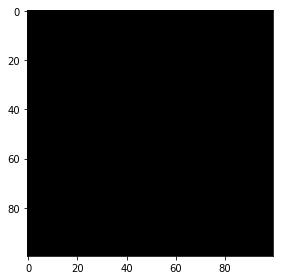

In [216]:
io.imshow(y[0])

In [251]:
from pickle import dump

from os import listdir
filenames = [filename for filename in listdir('./test/00_input/test/images/')]
with open('filenames.pickle', 'wb') as f:
    dump(filenames, f)

In [257]:
model.get_config()

[{'class_name': 'Normalizer',
  'config': {'batch_input_shape': (None, 100, 100, 3),
   'dtype': 'float32',
   'name': 'normalizer_7',
   'trainable': True}}]

In [264]:
Flatten().get_config()

{'name': 'flatten_9', 'trainable': True}

In [266]:
Normalizer(x_train).get_config()

{'name': 'normalizer_8', 'trainable': True}

In [254]:
model = Sequential.from_config(model.get_config(), custom_objects=[Normalizer])

ValueError: Unknown layer: Normalizer

In [268]:
from keras import layers
norm = Normalizer(x_train)

In [273]:
config = norm.get_config()

norm = layers.deserialize(config, custom_objects={'class_name': norm.__class__.__name__, 'config': config})

ValueError: Improper config format: {'name': 'normalizer_9', 'trainable': True}

In [34]:
from skimage.transform import resize
img = io.imread('img.jpg')

In [4]:
model = load_model('model.hd5f')

In [28]:
result_xy = model.predict(np.array([img]))[0]

In [33]:
result_xy

array([ 44.70410919,  20.5736618 ,  49.12076569,  19.59256744,
        53.92562103,  20.80966949,  58.11831284,  21.807024  ,
        45.13471222,  28.29666328,  46.78337479,  28.0046711 ,
        47.97982025,  28.67725372,  53.59081268,  29.49427795,
        55.22865295,  28.94285774,  56.58411407,  29.61835098,
        49.03063583,  48.61337662,  43.89920425,  63.25622177,
        47.04920578,  64.76573181,  50.58950043,  63.98792648], dtype=float32)

In [36]:
result_xy[::2] *= 262 / 100
result_xy[1::2] *= 262 / 100

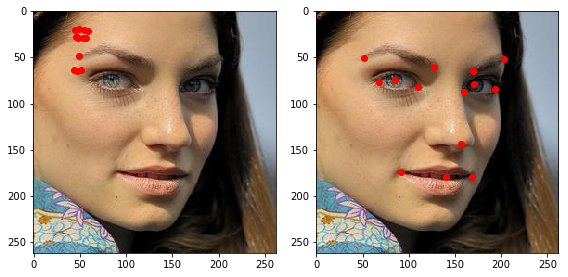

In [35]:
plt.figure(figsize=(8,9))

#result_xy = [55.4682536316,50.9432206726,122.535272369,59.225993309,167.122526398,65.171000824,207.696786041,59.9922621536,67.9678286362,71.2781242371,89.7531200409,72.7647271729,110.928641586,77.5379986954,162.485345078,83.8945899963,179.715964813,81.0115695572,198.331153564,84.2539225006,149.69841301,142.383053665,88.8024125671,164.025558548,133.821129456,174.230519714,165.564862518,169.649497528]
result = points_xy_as_dictionary(result_xy)
plt.subplot(121)
io.imshow(img)
plt.plot(result['x'], result['y'], 'ro')

true_xy = [51,51,127,60,169,65,203,52,68,77,85,75,110,82,160,87,171,79,193,84,156,144,92,174,140,180,168,179]
true = points_xy_as_dictionary(true_xy)
plt.subplot(122)
io.imshow(img)
plt.plot(true['x'], true['y'], 'ro')